In [1]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import neurokit2 as nk
from heartkit.defines import HeartTask
from heartkit.datasets.icentia11k import IcentiaDataset
from heartkit.datasets.ludb import LudbDataset
from heartkit.datasets.synthetic.rhythm_generator import nsr as syn_nsr, af as syn_af

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass


In [9]:
def plot_segmentations(data, labels, preds):
    color_map = {0: 'gray', 1: 'blue', 2: 'red', 3: 'green'}

    t = np.arange(0, data.shape[0])
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(t, data)
    if preds:
        pred_bnds = np.where(np.abs(np.diff(preds)) > 0)[0]
        pred_bnds = np.concatenate(([0], pred_bnds, [len(preds)-1]))
        for i in range(pred_bnds.shape[0]-1):   
            c = color_map.get(preds[pred_bnds[i]+1], '')
            ax.plot(t[pred_bnds[i]:pred_bnds[i+1]], data[pred_bnds[i]:pred_bnds[i+1]], color=c)

    return fig, ax


In [3]:
ds_path = "../datasets"
frame_size = 1248
frame_overlap = 312
frame_keep = frame_size - frame_overlap
patient = 194


In [6]:
ds = LudbDataset(
    ds_path=ds_path,
    task=HeartTask.segmentation,
    frame_size=frame_size
)

In [7]:
model = tf.keras.models.load_model("../results/segmentation/model.tf")

In [6]:
data, labels = ds.get_patient_data_segments(patient=patient)

In [7]:
y_pred = np.zeros_like(labels)
for lead_idx in range(data.shape[1]):
    for i in range(0, data.shape[0] - frame_keep + 1, frame_keep):
        y = model.predict(data[i:i+frame_size, lead_idx].reshape((1, frame_size, 1)), verbose=0).squeeze()
        y_pred[i:i+frame_keep, lead_idx] = y[:frame_keep].argmax(axis=1)
    # END FOR   
# END FOR

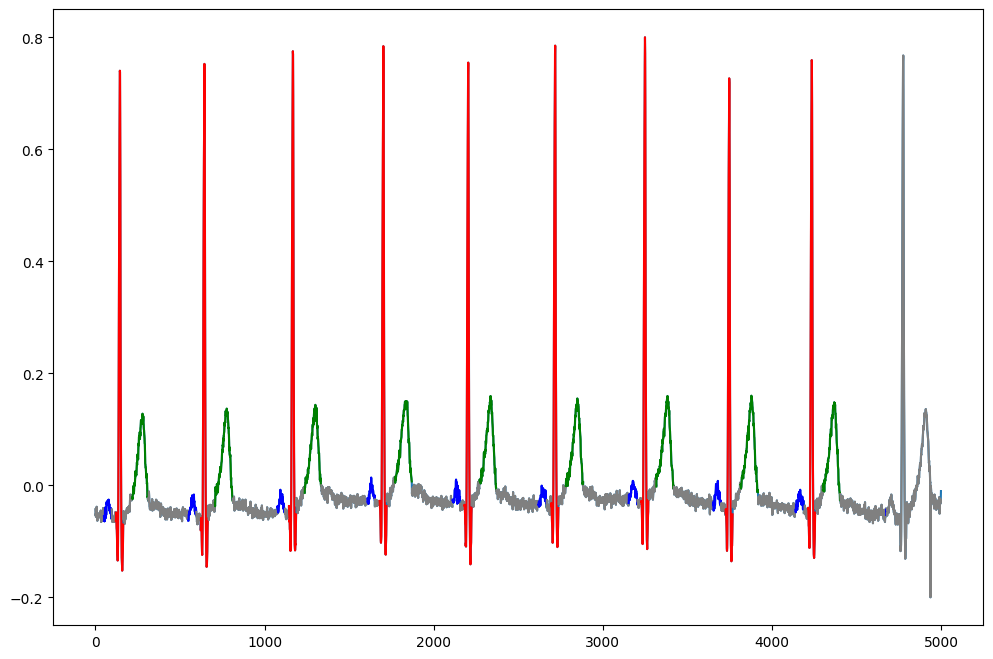

In [8]:
lead_idx = 10
fig, ax = plot_segmentations(data=data[:, lead_idx], labels=labels[:, lead_idx], preds=y_pred[:, lead_idx].squeeze())
fig.show()

In [18]:
ecg = nk.ecg_simulate(duration=10, heart_rate=60, sampling_rate=500)

In [19]:
y_pred = np.zeros_like(ecg)
for i in range(0, ecg.shape[0] - frame_keep + 1, frame_keep):
    y = model.predict(ecg[i:i+frame_size].reshape((1, frame_size, 1)), verbose=0).squeeze()
    y_pred[i:i+frame_keep] = y[:frame_keep].argmax(axis=1)
# END FOR  

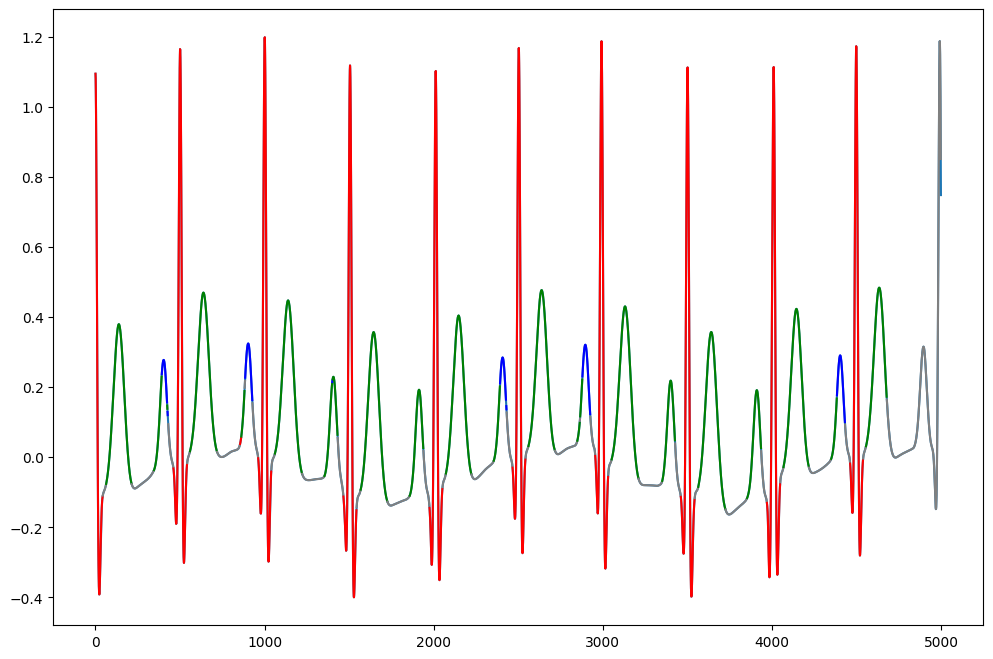

In [20]:
fig, ax = plot_segmentations(data=ecg, labels=None, preds=y_pred.squeeze())
fig.show()

* Use LUDB, QT, and Synthetic to train 
* Need to resample to 500 Hz (use all leads)
* Apply augmentations: inject noise, artifacts
* Apply filter, baseline wander removal, and normalize signal 

In [51]:
rst = syn_nsr(
    leads=12, 
    signal_frequency=1000, 
    rate=120,
    preset='SR',
    universal_noise_multiplier=0.8,
    impedance=1,
    p_multiplier=0.9,
    t_multiplier=0.8
)
data = 300*rst[1].transpose()[:5000, :]

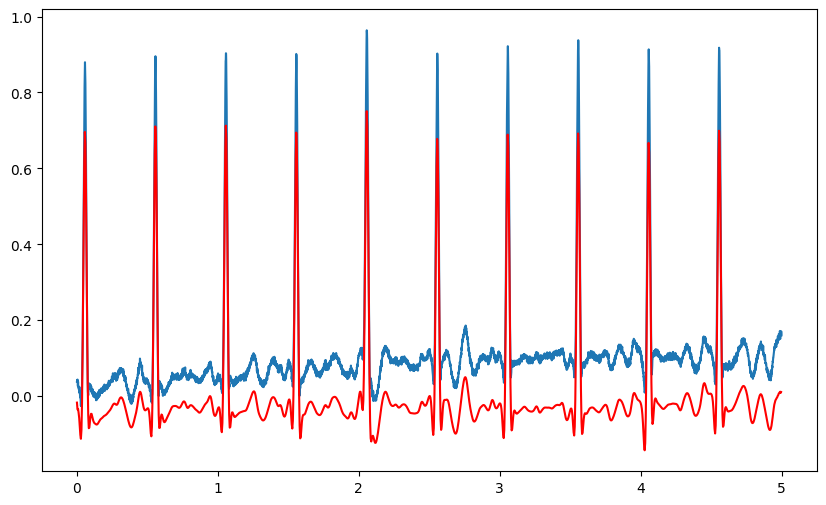

In [59]:
d1 = data[:, 0].squeeze()
d2 = nk.signal_filter(signal=d1, sampling_rate=1000, lowcut=0.5, highcut=30, method="butterworth", order=3)
d3 = nk.signal_resample(d2, sampling_rate=1000, desired_sampling_rate=250, method="FFT")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
t1 = np.arange(d2.shape[0])/1000.0
t3 = np.arange(d3.shape[0])/250.0
ax.plot(t1, d1)
ax.plot(t3, d3, color='red')



In [54]:
y_pred = np.zeros_like(labels)
for lead_idx in range(data.shape[1]):
    for i in range(0, data.shape[0] - frame_keep + 1, frame_keep):
        y = model.predict(data[i:i+frame_size, lead_idx].reshape((1, frame_size, 1)), verbose=0).squeeze()
        y_pred[i:i+frame_keep, lead_idx] = y[:frame_keep].argmax(axis=1)
    # END FOR   
# END FOR

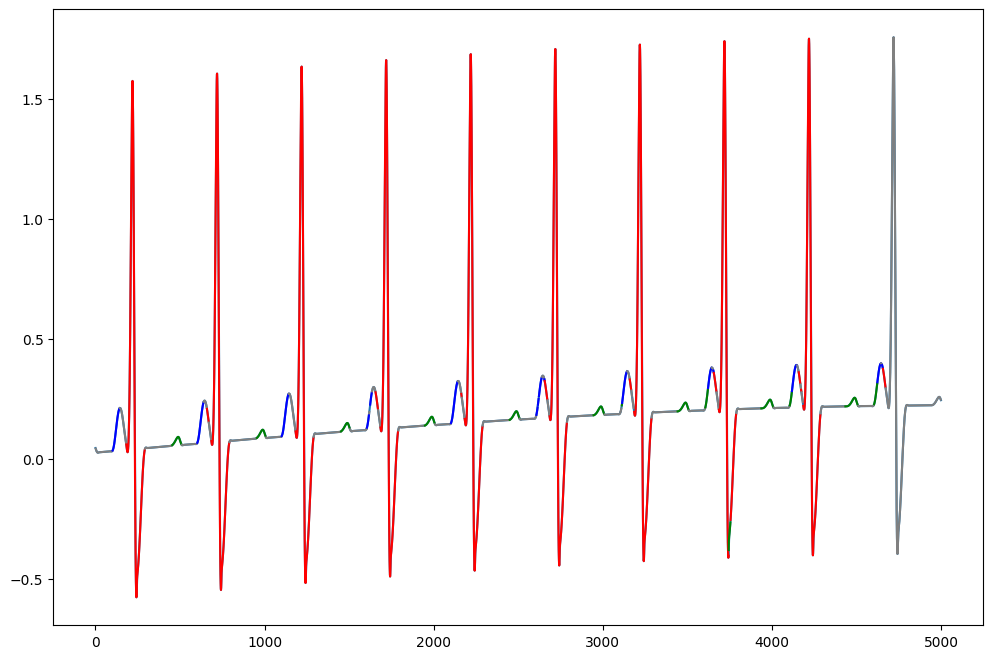

In [56]:
lead_idx = 9
fig, ax = plot_segmentations(data=data[:, lead_idx], labels=labels[:, lead_idx], preds=y_pred[:, lead_idx].squeeze())
fig.show()